# core

> core utils

[![](https://raw.githubusercontent.com/butchland/fastai-torchgeo/master/assets/colab.svg)](https://colab.research.google.com/github/butchland/fastai-torchgeo/blob/master/nbs/00_core.ipynb)

In [ ]:
#| default_exp core

In [ ]:
#| hide
# check if in colab and install package as needed
![ -e /content ] && ! pip show fastai-torchgeo && pip install git+https://github.com/butchland/fastai-torchgeo.git
![ -e /content ] && ! pip show nbdev && pip install nbdev

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| exporti
import rasterio as rio
import numpy as np
import pathlib
import torch as th
import fastai.vision.all as fv
import fastcore.all as fc
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Union
from functools import partial

## Load geotiff 

In [ ]:
#| export
def load_tif(fpath:str|pathlib.Path, # filename 
             chnls_last=True, # transpose from c,h,w to h,w,c (assume c,h,w on rio.read input)
            ) -> np.ndarray: # ndarray will either h,w,c or c,h,w depending on chnls_last is True or False
    """
    The `load_tif` function is designed to load a geotiff from a file, transpose its channels if necessary, and return the image data as a NumPy array.
    
    ## Parameters
    
    - `fpath` (str|pathlib.Path): The file path of the image to be loaded.
    - `chnls_last` (bool, optional): If set to `True`, the function will return the image data in the format (height, width, channels) (h, w, c). If set to `False`, the function will return the image data in the format (channels, height, width) (c, h, w). Default value is `True`.
    
    ## Returns
    
    - `numpy.ndarray`: The image data as a NumPy array. The shape of the array depends on the value of `chnls_last`.
      - If `chnls_last` is `True`, the returned array will have the shape `(height, width, channels)`.
      - If `chnls_last` is `False`, the returned array will have the shape `(channels, height, width)`.
    """
    with rio.open(fpath) as src:
        data = src.read()
    if chnls_last:
        return data.transpose([1,2,0]) # return as h,w,c
    return data

## Explore loading geotiffs

In [ ]:
from torchgeo.datasets import EuroSAT100

In [ ]:
# load a sample geotiff dataset
eurosat = fv.untar_data(EuroSAT100.url); eurosat

Path('/home/butch2/.fastai/data/EuroSAT100')

In [ ]:
eurosat.ls()

(#1) [Path('/home/butch2/.fastai/data/EuroSAT100/images')]

In [ ]:
sat_images = fv.get_image_files(eurosat); len(sat_images)

100

In [ ]:
sat_images[0]

Path('/home/butch2/.fastai/data/EuroSAT100/images/remote_sensing/otherDatasets/sentinel_2/tif/Residential/Residential_2162.tif')

In [ ]:
data = load_tif(sat_images[0]) # channels last is the default
data.shape # height,width, channels

(64, 64, 13)

In [ ]:
data = load_tif(sat_images[0], chnls_last=False)
data.shape # channels, height, width

(13, 64, 64)

## Load geotiff as pytorch tensor

In [ ]:
#| export
def open_tif(fn, chnls=None, chnls_last=True, cls=th.Tensor):
    arr = load_tif(fn, chnls_last=chnls_last)
    if chnls is not None:
        arr = arr[..., chnls] if chnls_last else arr[..., chnls, :,:]
    th_arr = th.from_numpy(arr.astype(np.int32)).type(th.float32)
    return cls(th_arr)


In [ ]:
t1 = open_tif(sat_images[0])

In [ ]:
type(t1)

torch.Tensor

In [ ]:
t1.shape

torch.Size([64, 64, 13])

## Geotiff tensor image class

In [ ]:
#| export
class GeoTensorImage(fv.TensorImage):
    
    def __init__(self, x, chnls_first=False):
        self.chnls_first = chnls_first
    def __repr__(self):
        return (f'GeoTensorImage: {self.shape}')
        
    @classmethod
    def create(cls, data:Union[Path,str,np.ndarray], chnls=None, chnls_first=True):
        
        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('tif'): im = open_tif(fn=data, chnls=chnls, chnls_last = not chnls_first, cls=th.Tensor)
        elif isinstance(data, np.ndarray):
            if chnls_first:
                # assume chnls last coming in
                if data.shape[-1] == 12:
                    data = bc.add_last_dimension(data) # add 1 to make chnls 13
                data = data.transpose([2,0,1]) # data out  as c,h,w
            im = th.from_numpy(data)
        else:
            im = data
        
        return cls(im, chnls_first=chnls_first)

In [ ]:
#| export 
@fc.patch
def show(self:GeoTensorImage, chnls=[3, 2, 1], scaler=1.0, bright=1.0, ctx=None):
    
    if self.ndim > 2:
        visu_img = self[..., chnls] if not self.chnls_first else self.permute([1, 2, 0])[..., chnls]
    else:
        visu_img = self
    
    visu_img = visu_img.squeeze()
    if scaler is None:
        visu_img /= visu_img.max()
    else:
        visu_img /= visu_img.max() * scaler
        
    visu_img *= bright
    visu_img = np.where(visu_img > 1, 1, visu_img)
    visu_img = np.where(visu_img < 0, 0, visu_img)
    
    plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)
    
    return ctx
 

In [ ]:
geo_img = GeoTensorImage.create(sat_images[0])

In [ ]:
type(geo_img)

__main__.GeoTensorImage

In [ ]:
geo_img

GeoTensorImage: torch.Size([13, 64, 64])

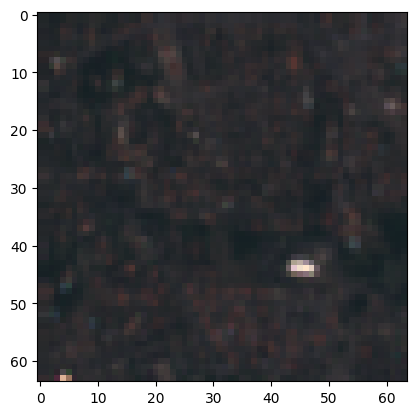

In [ ]:
geo_img.show()

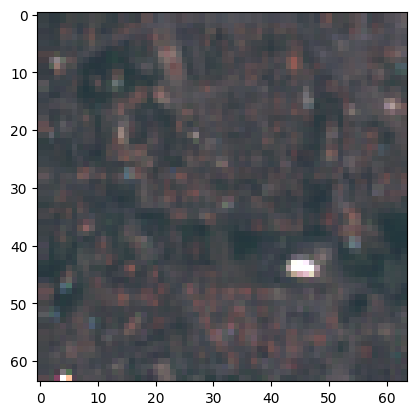

In [ ]:
geo_img.show(bright=1.7)

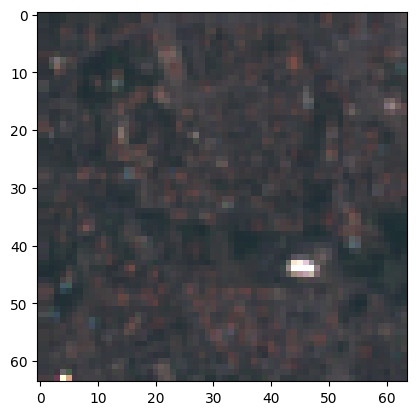

In [ ]:
geo_img.show(scaler=0.7)

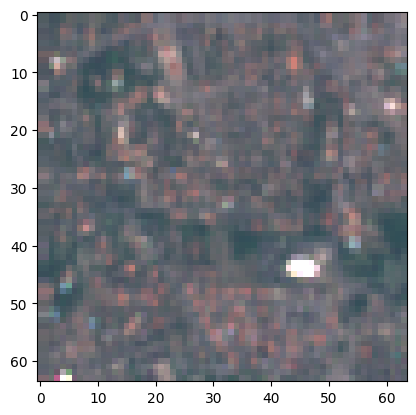

In [ ]:
geo_img.show(scaler=0.7, bright=1.7)